In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import tabulate
import sys
import os
from scipy import stats
from autorank import autorank,create_report,plot_stats
from significance_analysis import conduct_analysis
pd.set_option("chained_assignment", None)
pd.set_option("display.max_rows", 5000)
pd.set_option("display.max_columns", 5000)
pd.set_option("display.width", 10000)

def load_priorband_data(combine_bench_prior:bool=True):
    df = pd.read_parquet("data_for_anton.parquet")
    df=df.reset_index()
    df_collection=[]
    for seed_nr in range(50):
        partial_df=df[["benchmark","prior","algorithm","used_fidelity"]]
        partial_df["value"]=df[f"seed-{seed_nr}"]
        partial_df["seed"]=seed_nr
        df_collection.append(partial_df)
        print(f"⚙️ Seed {seed_nr+1}/50", end="\r", flush=True)
    complete_df=pd.concat(df_collection,ignore_index=True)
    
    if combine_bench_prior:
        def combine_bench_priors(row):
            return f"{row['benchmark']}_{row['prior']}"
        complete_df["bench_prior"]=complete_df.apply(combine_bench_priors,axis=1)
    print("✅ Loading data done")
    print(complete_df)
    return complete_df

def add_regret(df:pd.DataFrame,normalize:False):
    best={}
    ranges={}
    print("⚙️ Preparing regret", end="\r", flush=True)
    for benchmark in df["benchmark"].unique():
        best[benchmark]=min(df.loc[df["benchmark"]==benchmark]["value"])
        ranges[benchmark]=max(df.loc[df["benchmark"]==benchmark]["value"])-best[benchmark]
        
    def calculate_simple_regret(row,normalize:bool=False):
        if normalize:
            return abs(best[row["benchmark"]]-row["value"])/ranges[row["benchmark"]]
        return abs(best[row["benchmark"]]-row["value"])
    
    if normalize:
        print("⚙️ Adding regret       ", end="\r", flush=True)
        df['regret'] = df.apply(calculate_simple_regret, axis=1,normalize=True)
        print("✅ Adding regret done                      ")
    else:
        print("⚙️ Adding normalized regret       ", end="\r", flush=True)
        df['norm_regret'] = df.apply(calculate_simple_regret, axis=1,normalize=False)
        print("✅ Adding normalized regret done                      ")
    return df

def create_df_dict(df:pd.DataFrame,experiment:dict):
    df_dict={}
    for p_n,prior_key in enumerate(experiment["priors"]):
        df_dict[prior_key]={}
        for b_n,benchmark in enumerate(experiment["benchmarks"]):
            print(f"⚙️ Prior {prior_key} ({p_n+1}), Benchmark {b_n+1}/{len(experiment['benchmarks'])}      ", end="\r", flush=True)
            df_dict[prior_key][benchmark]={}
            for algo_key,algo_value in experiment["algo_dict"].items():
                df_dict[prior_key][benchmark][algo_key]=df.loc[(df["prior"].isin(experiment["prior_dict"][prior_key]))&(df["algorithm"].isin(algo_value))&(df["benchmark"]==benchmark)&(df["used_fidelity"]>=experiment["min_f"])].reset_index(drop=True)
    print("✅ Creating df-dict done                     ")
    return df_dict

def create_lmem_incumbent(df_dict:pd.DataFrame,experiment:dict,cumulative:bool=False,value:list[str]=["value"]):
    fs=experiment["f_space"]
    algorithms=experiment["algorithms"]
    algo_group=experiment["algo_group"]
    benchmarks=experiment["benchmarks"]
    priors=experiment["priors"]
    
    output={}
    output["dataset"]={}
    for p_n,prior in enumerate(priors):
        output["dataset"][prior]={}
        for n_f,max_f in enumerate(fs):
            output["dataset"][prior][max_f]={}
            output["dataset"][prior][max_f]=pd.DataFrame()
            for b_n,benchmark in enumerate(benchmarks):
                df_at_point=df_dict[prior][benchmark][algo_group]
                df_at_point=df_at_point.loc[df_at_point["used_fidelity"]<=max_f]
                for seed in df_at_point["seed"].unique():
                    print(f"⚙️ Prior {prior} ({p_n+1}), Fidelity {n_f+1}/{len(fs)}, Benchmark {b_n+1}/{len(benchmarks)}          ", end="\r", flush=True)
                    for algo in algorithms:
                        if len(df_at_point.loc[(df_at_point["seed"]==seed)&(df_at_point["algorithm"]==algo)])>0:
                            df_criteria=df_at_point.loc[(df_at_point["seed"]==seed)&(df_at_point["algorithm"]==algo)].iloc[-1].to_frame().T
                            df_criteria["used_fidelity"]=max_f
                            output["dataset"][prior][max_f]=pd.concat([output["dataset"][prior][max_f],df_criteria],ignore_index=True)
            output["dataset"][prior][max_f][value+["used_fidelity"]]=output["dataset"][prior][max_f][value+["used_fidelity"]].astype(float)
            output["dataset"][prior][max_f]["seed"]=output["dataset"][prior][max_f]["seed"].astype(int)
    print("✅ Creating incumbent data done                                              ")
    if not cumulative:
        return output["dataset"]
    cumulative_data={}
    for p_n,prior in enumerate(priors):
        cumulative_data[prior]={}
        for max_f in experiment["budgets"]:
            cumulative_data[prior][max_f]=pd.DataFrame()
            for fidelity in [item for item in experiment["f_space"] if experiment["min_f"] <= item <= max_f]:
                cumulative_data[prior][max_f]=pd.concat([cumulative_data[prior][max_f],output["dataset"][prior][fidelity]],ignore_index=True)

    return cumulative_data

def run_lmems(experiment:dict,values:list[str]=["value"]):
    result_dict={}
    for v_n,value in enumerate(values):
        result_dict[value]={}
        for p_n,priortype in enumerate(experiment["priors"]):
            result_dict[value][priortype]={}
            for f_n,max_f in enumerate(experiment["budgets"]):
                print(f"⚙️ Value {value}({v_n+1}), Prior {priortype}({p_n+1}), Fidelity {f_n+1}/{len(experiment['budgets'])}        ", end="\r", flush=True)
                experiment["dataset"][priortype][max_f]=experiment["dataset"][priortype][max_f].replace({"algorithm": experiment["label_dict"],"benchmark": experiment["label_dict"]})
                real_stdout = sys.stdout
                sys.stdout = open(os.devnull, "w")
                if len(experiment["dataset"][priortype][max_f]["used_fidelity"].unique())>1:
                    print(experiment["dataset"][priortype][max_f]["used_fidelity"].unique())
                    result_dict[value][priortype][max_f]=conduct_analysis(experiment["dataset"][priortype][max_f],value,"algorithm","benchmark",bin_id="used_fidelity",continuous_fidelity=False,show_plots=True,verbosity=2)[1]
                else:
                    result_dict[value][priortype][max_f]=conduct_analysis(experiment["dataset"][priortype][max_f],value,"algorithm","benchmark",continuous_fidelity=False,show_plots=False,verbosity=0)[1]
                sys.stdout = real_stdout
    print("✅ Running experiments done                                                             ")
    return result_dict

def plot_cd_diagrams(experiment:dict,value:str="value"):
    color_dict={"random_search":"red","hyperband":"green","pb_mutation_dynamic_geometric-default-at-target":"blue","priorband":"blue","RS":"red","HB":"green","PB":"blue"}

    _ = plt.figure(figsize=(10,10*len(experiment["budgets"])/3))
    gs=GridSpec(nrows=len(experiment["budgets"]),ncols=len(experiment["priors"]))
    for p_n,prior in enumerate(experiment["priors"]):
        for f_n,fidelity in enumerate(experiment["budgets"]):
            if fidelity>experiment["min_f"] and experiment["granularity"]:
                scoreframe=experiment["result_dict"][value][prior][fidelity][0].loc[experiment["result_dict"][value][prior][fidelity][0]["used_fidelity_bins"]==str(float(fidelity))].sort_values(by=['Estimate'])[["algorithm","Estimate"]]
                contrastframe=experiment["result_dict"][value][prior][fidelity][1].loc[experiment["result_dict"][value][prior][fidelity][1]["used_fidelity_bins"]==str(float(fidelity))][["Sig","algorithm_1","algorithm_2"]]
            else:
                scoreframe=experiment["result_dict"][value][prior][fidelity][0].sort_values(by=['Estimate'])[["algorithm","Estimate"]]
                contrastframe=experiment["result_dict"][value][prior][fidelity][1][["Sig","algorithm_1","algorithm_2"]]

            min_score=scoreframe["Estimate"][0]
            max_score=scoreframe["Estimate"][len(scoreframe["Estimate"])-1]

            significance_lines=[]
            for n_best_algo,best_algo in enumerate(scoreframe["algorithm"]):
                for n_worst_algo,worst_algo in reversed(list(enumerate(scoreframe["algorithm"][n_best_algo+1:]))):
                    significance=contrastframe.loc[((contrastframe["algorithm_1"]==best_algo)&(contrastframe["algorithm_2"]==worst_algo))|((contrastframe["algorithm_2"]==best_algo)&(contrastframe["algorithm_1"]==worst_algo))]["Sig"][0]
                    if significance in ["","."]:
                        new_line=[n_best_algo,n_best_algo+n_worst_algo+1]
                        if not any(existing_pair[0] <= new_line[0] <= existing_pair[1] and existing_pair[0] <= new_line[1] <= existing_pair[1] for existing_pair in significance_lines):
                            significance_lines.append([n_best_algo,n_best_algo+n_worst_algo+1])
                            break
            n_sign_lines=len(significance_lines)
            plot_height=10+5

            ax=plt.subplot(gs[f_n,p_n])
            
            ax.set_title(f"{fidelity}x {prior}",pad=0,y=-0.18)
            ax.get_yaxis().set_visible(False)
            ax.set_xlim(min_score-(max_score-min_score)*0.1,max_score+(max_score-min_score)*0.1)
            ax.set_ylim(0,plot_height)
            ax.spines['bottom'].set_position(('data', 0.0))
            ax.spines[['top',"left","right"]].set_visible(False)
            ax.invert_xaxis()

            for algo in range(len(scoreframe["Estimate"])):
                ax.plot([scoreframe["Estimate"][algo],scoreframe["Estimate"][algo]], [0, plot_height-6], '-', lw=2, label="_not in legend",color=color_dict[scoreframe["algorithm"][algo]])
                ax.text(scoreframe["Estimate"][algo], plot_height-3, scoreframe["algorithm"][algo], horizontalalignment='center',verticalalignment='bottom')
                ax.text(scoreframe["Estimate"][algo], plot_height-5, np.round(scoreframe["Estimate"][algo],2), horizontalalignment='center',verticalalignment='bottom')
            for n_line,line in enumerate(significance_lines):
                if scoreframe["Estimate"][line[0]]==scoreframe["Estimate"][line[1]]:
                    ax.plot([scoreframe["Estimate"][line[0]], scoreframe["Estimate"][line[1]]],[10/(n_sign_lines+1)*(n_line+1)-0.5,10/(n_sign_lines+1)*(n_line+1)+0.5],  '-', lw=2, label="_not in legend",color="gray")
                else:
                    ax.plot([scoreframe["Estimate"][line[0]], scoreframe["Estimate"][line[1]]],[10/(n_sign_lines+1)*(n_line+1),10/(n_sign_lines+1)*(n_line+1)],  '-', lw=6, label="_not in legend",color="gray")
    print(f"Granularity: {experiment['granularity']}, Value: {value}")
    plt.show()


In [3]:
def run_experiment(priors:list[str]=["good+bad"],budgets:list[float]=[1.0,5.0,12.0],granularity:int=0,value:list[str]=["value"],min_f:float=1.0):
    experiment={}
    experiment["algo_dict"]={"rs_hb_pb":["random_search","hyperband","pb_mutation_dynamic_geometric-default-at-target"]}
    experiment["prior_dict"]={"good+bad":["at25","bad"],"good":["at25"],"bad":["bad"]}
    experiment["benchmarks"]=["jahs_cifar10","jahs_colorectal_histology","jahs_fashion_mnist","lcbench-126026","lcbench-167190","lcbench-168330","lcbench-168910","lcbench-189906","cifar100_wideresnet_2048","imagenet_resnet_512","lm1b_transformer_2048","translatewmt_xformer_64"]
    experiment["label_dict"]={'random_search': 'RS', 'hyperband': 'HB', 'pb_mutation_dynamic_geometric-default-at-target': 'PB', 'jahs_cifar10': 'JAHS-C10', 'jahs_colorectal_histology': 'JAHS-CH', 'jahs_fashion_mnist': 'JAHS-FM', 'lcbench-126026': 'LC-126026', 'lcbench-167190': 'LC-167190', 'lcbench-168330': 'LC-168330', 'lcbench-168910': 'LC-168910', 'lcbench-189906': 'LC-189906', 'cifar100_wideresnet_2048': 'PD1-Cifar100', 'imagenet_resnet_512': 'PD1-ImageNet', 'lm1b_transformer_2048': 'PD1-LM1B', 'translatewmt_xformer_64': 'PD1-WMT',"random_search_prior":"RS+Prior","bo":"BO","pibo":"PiBO","bohb":"BOHB","priorband_bo":"PriorBand+BO"}
    experiment["algo_group"]="rs_hb_pb"
    experiment["algorithms"]=experiment["algo_dict"][experiment["algo_group"]]
    experiment["priors"]=priors
    experiment["budgets"]=budgets
    experiment["min_f"]=min_f
    experiment["granularity"]=granularity

    df=load_priorband_data()
    if "regret" in value:
        df=add_regret(df,False)
    if "norm_regret" in value:
        df=add_regret(df,True)
    df_dict=create_df_dict(df,experiment)
    
    if experiment["granularity"]>0:
        experiment["f_space"]=np.round(np.linspace(experiment["min_f"],max(experiment["budgets"]),(experiment["granularity"]*round(max(experiment["budgets"])-experiment["min_f"]))+1),3).tolist()
    elif experiment["granularity"]==-1:
        experiment["f_space"]=set()
        for prior in experiment["priors"]:
            for benchmark in experiment["benchmarks"]:
                experiment["f_space"].update(np.round(df_dict[prior][benchmark][experiment["algo_group"]]["used_fidelity"].unique(),2))
        experiment["f_space"]=list(experiment["f_space"])
        experiment["f_space"].sort()
        np.clip(experiment["f_space"],experiment["min_f"],max(experiment["budgets"]))
    else:
        experiment["f_space"]=experiment["budgets"]


    experiment["dataset"]=create_lmem_incumbent(df_dict,experiment,cumulative=experiment["granularity"],value=value)
    experiment["result_dict"]=run_lmems(experiment,value)
    for v in value:
        plot_cd_diagrams(experiment,v)

In [4]:
run_experiment(priors=["good+bad"],budgets=[5,12],value=["value"])

✅ Loading data done
              benchmark prior                                     algorithm  used_fidelity     value  seed          bench_prior
0        lcbench-167190   bad  pb_mutation_dynamic_linear-default-at-target       1.000000  0.521580     0   lcbench-167190_bad
1        lcbench-167190   bad  pb_mutation_dynamic_linear-default-at-target       1.019231  0.445254     0   lcbench-167190_bad
2        lcbench-167190   bad  pb_mutation_dynamic_linear-default-at-target       1.038462  0.445254     0   lcbench-167190_bad
3        lcbench-167190   bad  pb_mutation_dynamic_linear-default-at-target       1.057692  0.443823     0   lcbench-167190_bad
4        lcbench-167190   bad  pb_mutation_dynamic_linear-default-at-target       1.076923  0.443823     0   lcbench-167190_bad
...                 ...   ...                                           ...            ...       ...   ...                  ...
4574995  lcbench-168330  at25      pb_mutation_dynamic_50-default-at-target      20.

KeyboardInterrupt: 

✅ Loading data done
✅ Adding normalized regret done                      
✅ Adding regret done                      
✅ Creating df-dict done                     
✅ Creating incumbent data done                                              
✅ Running experiments done                                                             
Granularity: 1, Value: value


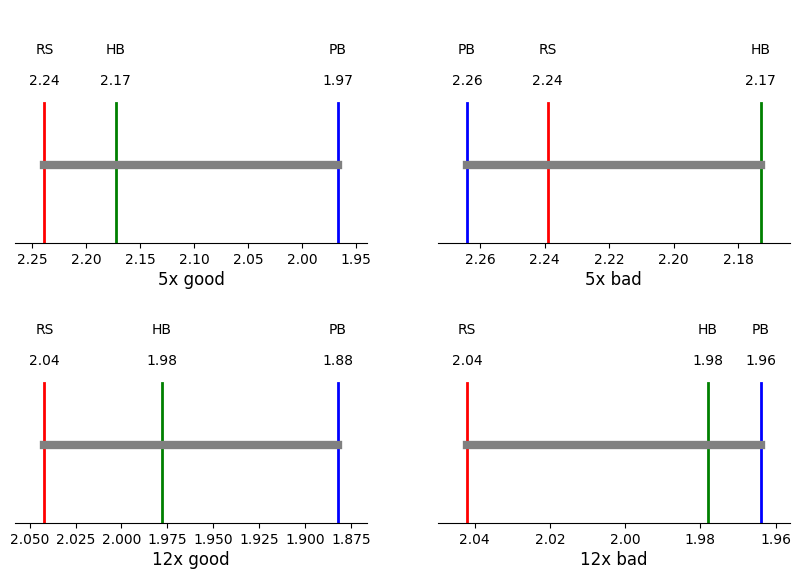

Granularity: 1, Value: regret


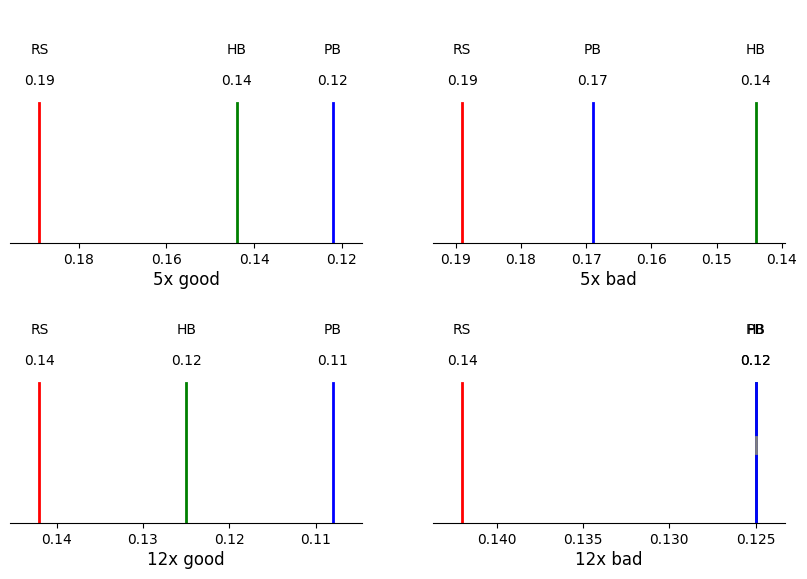

Granularity: 1, Value: norm_regret


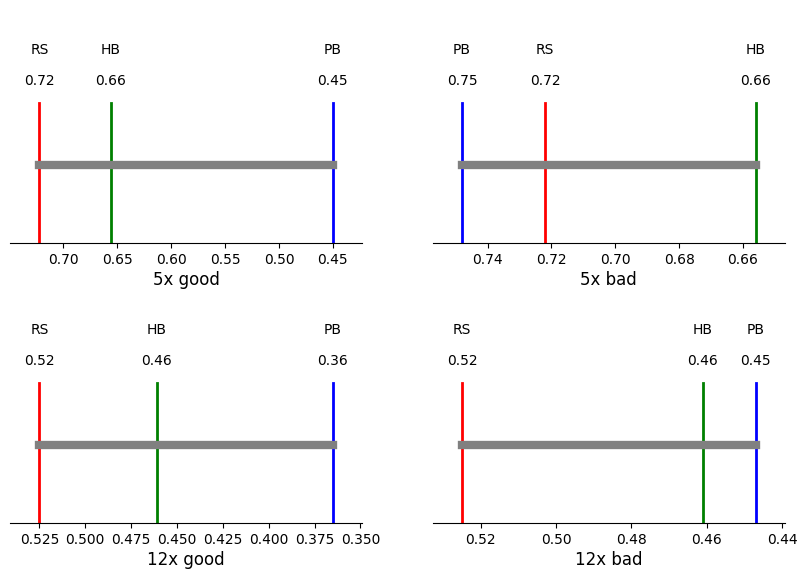

In [4]:
run_experiment(priors=["good","bad"],budgets=[5,12],granularity=1,value=["value","regret","norm_regret"])

✅ Loading data done
✅ Adding normalized regret done                      
✅ Adding regret done                      
✅ Creating df-dict done                     
✅ Creating incumbent data done                                              
✅ Running experiments done                                                             
Granularity: 5, Value: value


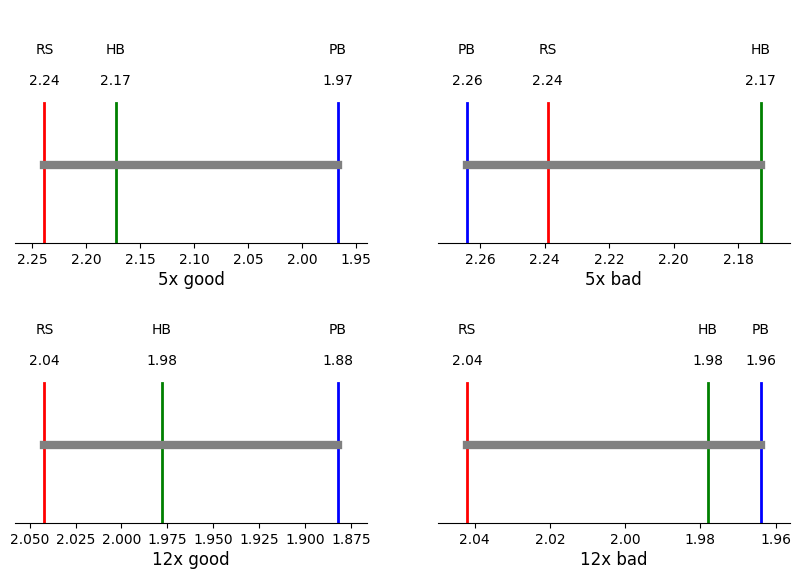

Granularity: 5, Value: regret


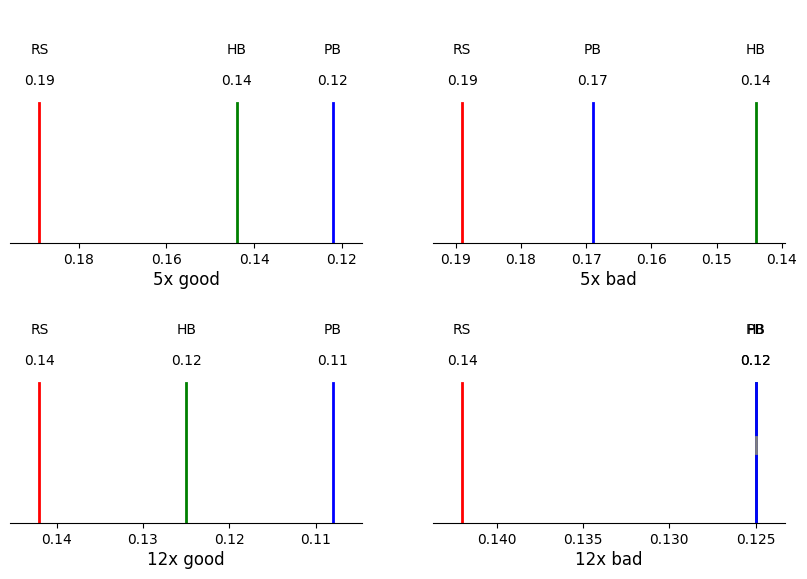

Granularity: 5, Value: norm_regret


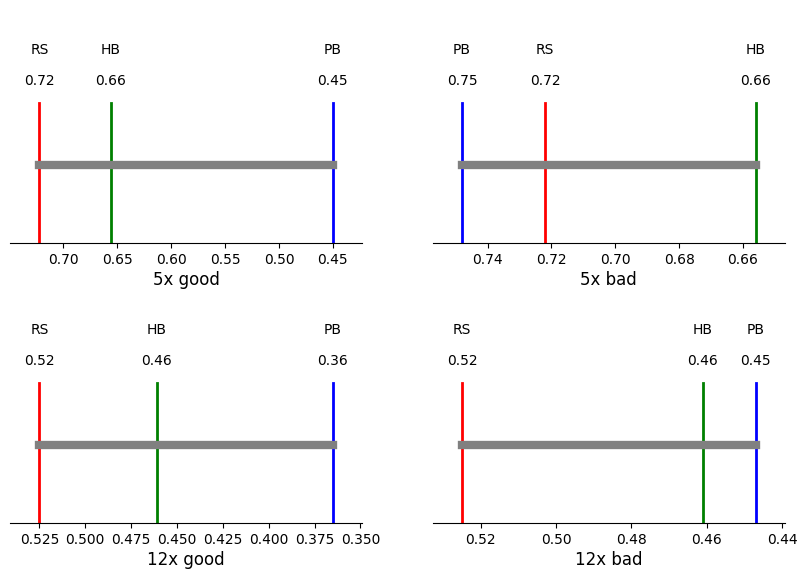

In [5]:
run_experiment(priors=["good","bad"],budgets=[5,12],granularity=5,value=["value","regret","norm_regret"])

✅ Loading data done
✅ Adding normalized regret done                      
✅ Adding regret done                      
✅ Creating df-dict done                     
✅ Creating incumbent data done                                              
✅ Running experiments done                                                             
Granularity: 10, Value: value


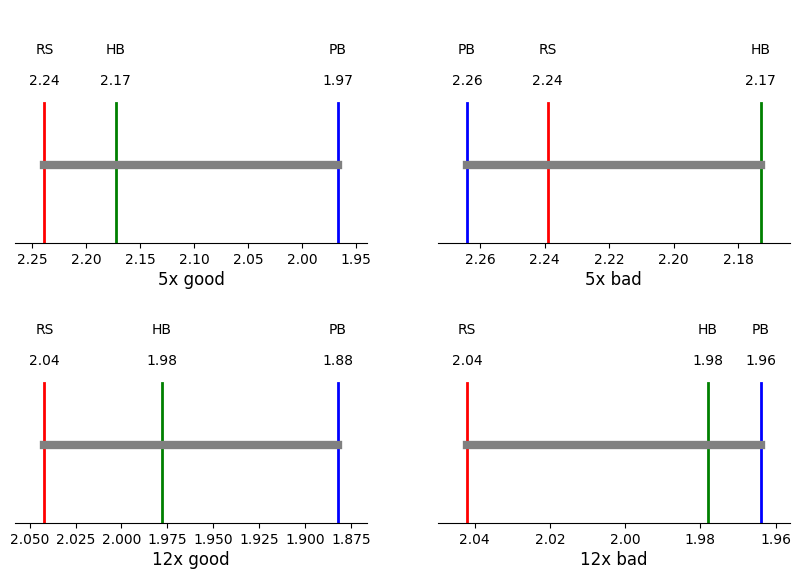

Granularity: 10, Value: regret


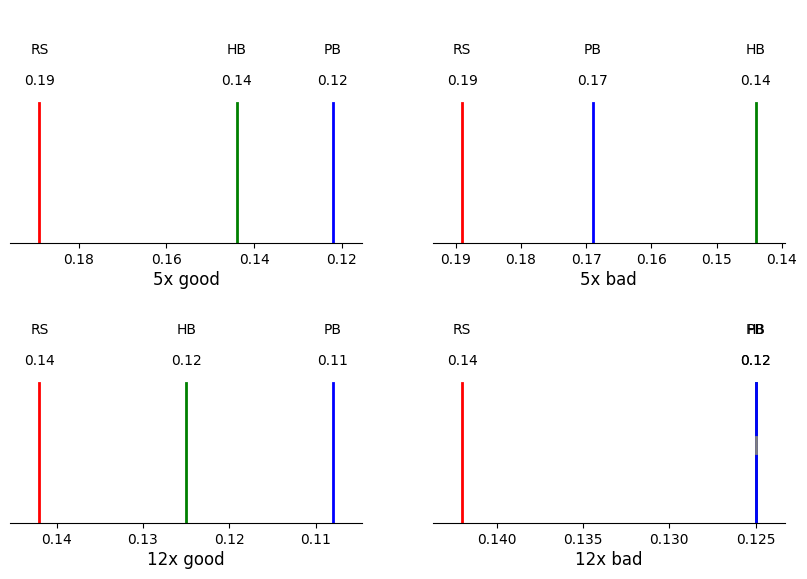

Granularity: 10, Value: norm_regret


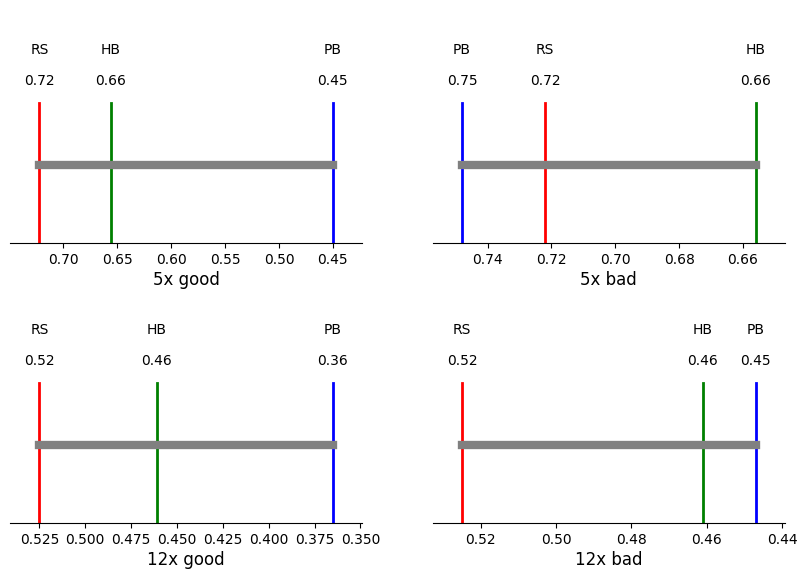

In [6]:
run_experiment(priors=["good","bad"],budgets=[5,12],granularity=10,value=["value","regret","norm_regret"])

✅ Loading data done
✅ Adding normalized regret done                      
✅ Adding regret done                      
✅ Creating df-dict done                     
✅ Creating incumbent data done                                              
✅ Running experiments done                                                             
Granularity: 15, Value: value


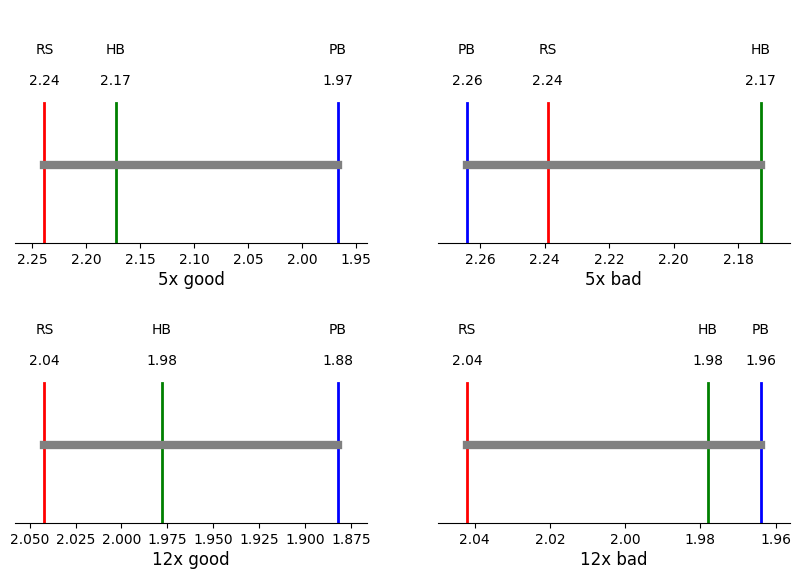

Granularity: 15, Value: regret


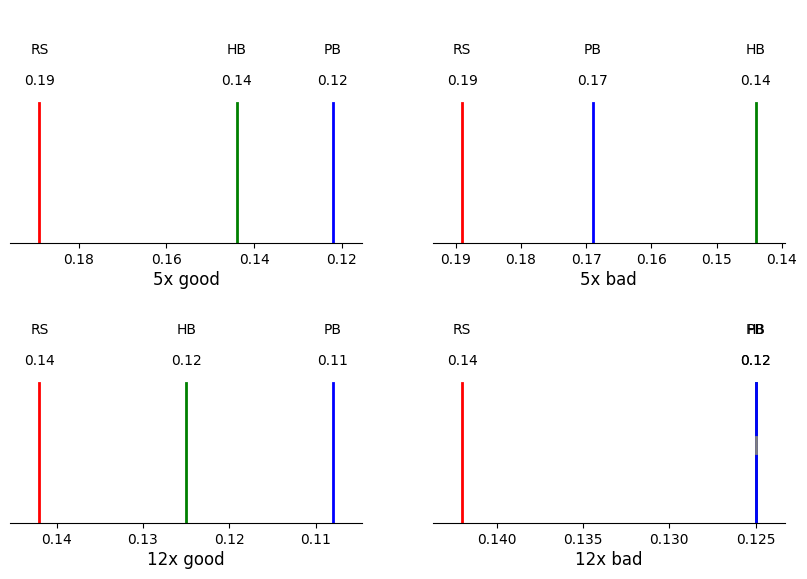

Granularity: 15, Value: norm_regret


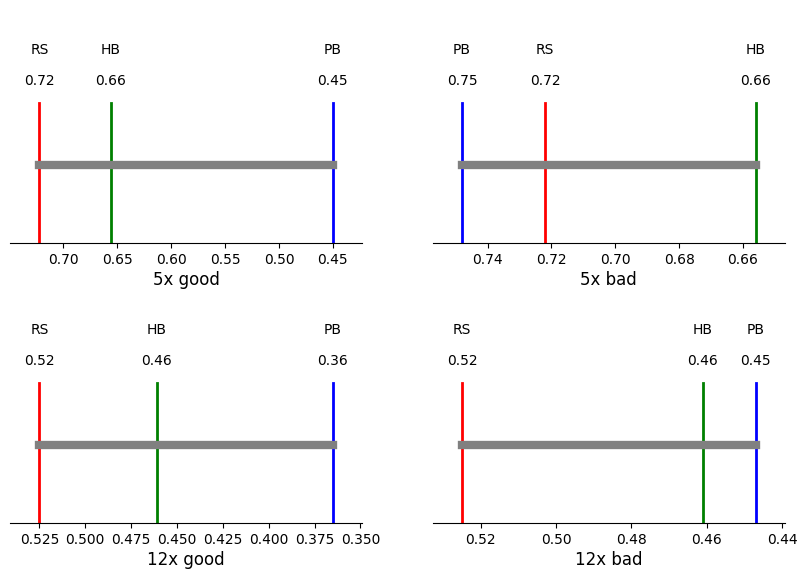

In [7]:
run_experiment(priors=["good","bad"],budgets=[5,12],granularity=15,value=["value","regret","norm_regret"])